In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from matplotlib import cm
import GPy
from sklearn.metrics import mean_squared_error

import sys
sys.path.insert(0,'/gpfs/home/dshak/Reference_Data')
from rna_codons import CODONS

#Remove U amino acid because is not used in dataset, rare amino acid (start or sel)
AMINOACID_KEYS = list(set(CODONS.values()) - set(['_','U']))
CODON_KEYS = list(set(CODONS.keys()))

np.random.seed(1)
%matplotlib inline

* Some values may need to be log transformed to give a gaussian distribution over values/standardize values as well
* Try cds length/gene length, utr5 length and utr3 length, cds_gc, log10 molecular mass, eq4wright, amino acids

In [2]:
adrenal = pd.read_csv('../Data/GP_inputs/adrenal_gp.tsv',sep='\t',index_col=0)
adrenal['MolecularMass'] = np.log10(adrenal['MolecularMass'])
adrenal['GeneLength'] = np.log10(adrenal['GeneLength'])
adrenal['CDS_length'] = np.log10(adrenal['CDS_length'])
adrenal['UTR5_length'] = np.log10(adrenal['UTR5_length'])
adrenal['UTR3_length'] = np.log10(adrenal['UTR3_length'])


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:Columns (111) have mixed types. Specify dtype option on import or set low_memory=False.


### Train and test

In [3]:
np.random.seed(1)
train_partition = 0.8
msk = np.random.rand(len(adrenal)) < train_partition
adrenal_train = adrenal[msk]
adrenal_test = adrenal[~msk]

### Chromosome 1

In [4]:
AdrTrn1 = adrenal_train[adrenal_train['Chromosome Name']=='1']
AdrTst1 = adrenal_test[adrenal_test['Chromosome Name']=='1']

In [5]:
features = AMINOACID_KEYS + CODON_KEYS + ['Adrenal_mRNA',
                                          'Adrenal_protein',
                                          'GeneLength',
                                          'CDS_length',
                                          'UTR5_length',
                                          'UTR3_length',
                                          'transcript_counts',
                                          'cds_gc',
                                          'utr5_gc',
                                          'utr3_gc',
                                          'MolecularMass',
                                          'eq4Wright',
                                          'eq2Sun',
                                          'eq5Sun']

In [16]:
list(AdrTrn1.columns)

['P',
 'D',
 'Q',
 'E',
 'F',
 'M',
 'G',
 'A',
 'S',
 'W',
 'R',
 'K',
 'H',
 'L',
 'Y',
 'V',
 'I',
 'T',
 'N',
 'C',
 'CGG',
 'AAC',
 'GUG',
 'CCU',
 'GCG',
 'ACG',
 'AGA',
 'UAG',
 'AAA',
 'GAC',
 'GAG',
 'GCC',
 'UCA',
 'AUG',
 'CGU',
 'GUC',
 'UGU',
 'UGG',
 'CGC',
 'CUC',
 'GUA',
 'UCC',
 'CUG',
 'UCG',
 'CAC',
 'UUA',
 'CAA',
 'CAU',
 'ACU',
 'CGA',
 'CCG',
 'UAU',
 'AGC',
 'CCC',
 'GUU',
 'AUA',
 'GGA',
 'GGC',
 'AAG',
 'AUC',
 'GCA',
 'AGG',
 'ACA',
 'GGG',
 'UUG',
 'GCU',
 'UCU',
 'UGA',
 'UAA',
 'GAU',
 'CCA',
 'UUU',
 'UAC',
 'CAG',
 'AAU',
 'AUU',
 'GAA',
 'ACC',
 'CUU',
 'UGC',
 'CUA',
 'UUC',
 'GGU',
 'AGU',
 'Adrenal_mRNA',
 'Adrenal_protein',
 'GeneLength',
 'CDS_length',
 'UTR5_length',
 'UTR3_length',
 'transcript_counts',
 'cds_gc',
 'utr5_gc',
 'utr3_gc',
 'MolecularMass',
 'eq4Wright',
 'eq2Sun',
 'eq5Sun']

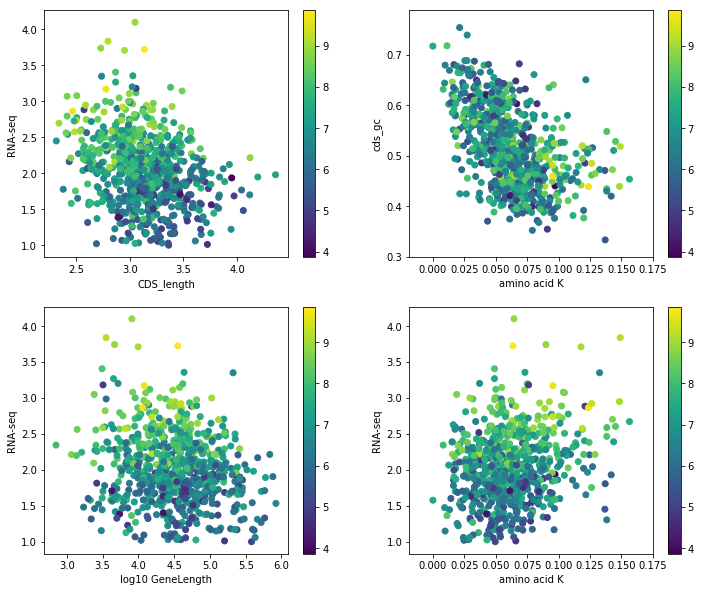

In [7]:
fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.add_subplot(221)
sc = ax.scatter(AdrTrn1['CDS_length'],AdrTrn1['Adrenal_mRNA'],c=AdrTrn1['Adrenal_protein'],cmap = cm.viridis)
ax.set_xlabel('CDS_length')
ax.set_ylabel('RNA-seq')
plt.colorbar(sc)

ax3 = fig.add_subplot(222)
sc = ax3.scatter(AdrTrn1['K'],AdrTrn1['cds_gc'],c=AdrTrn1['Adrenal_protein'],cmap = cm.viridis)
ax3.set_xlabel('amino acid K')
ax3.set_ylabel('cds_gc')
plt.colorbar(sc)

ax2 = fig.add_subplot(223)
sc = ax2.scatter(AdrTrn1['GeneLength'],AdrTrn1['Adrenal_mRNA'],c=AdrTrn1['Adrenal_protein'],cmap = cm.viridis)
ax2.set_xlabel('log10 GeneLength')
ax2.set_ylabel('RNA-seq')
plt.colorbar(sc)

ax4 = fig.add_subplot(224)
sc = ax4.scatter(AdrTrn1['K'],AdrTrn1['Adrenal_mRNA'],c=AdrTrn1['Adrenal_protein'],cmap = cm.viridis)
ax4.set_xlabel('amino acid K')
ax4.set_ylabel('RNA-seq')
plt.colorbar(sc)

#### Standardize data prior to forming model

In [7]:
#Standardize over chromosome 1
AdrTrn1 = AdrTrn1[features]
AdrTst1 = AdrTst1[features]
means = AdrTrn1.mean(axis=0)
stds = AdrTrn1.std(axis=0)
AdrTrn1 = (AdrTrn1-means)/stds
AdrTst1 = (AdrTst1-means)/stds
AdrTrn1.head()

,P,D,Q,E,F,M,G,A,S,W,...,UTR5_length,UTR3_length,transcript_counts,cds_gc,utr5_gc,utr3_gc,MolecularMass,eq4Wright,eq2Sun,eq5Sun
GeneName,,,,,,,,,,,,,,,,,,,,,
ABCB10,0.042862,-1.444698,-1.275471,-0.910592,0.253821,-0.260240,1.493850,1.868927,0.184667,0.316273,...,-1.211713,0.495403,-0.841161,0.609726,1.445020,-1.465477,0.598116,1.136054,0.841852,0.678306
ABCD3,-0.996847,-0.525887,-0.735872,-0.589395,0.670294,0.721693,0.387676,-1.026754,-0.759477,-0.555283,...,-1.779673,0.463669,-0.313866,-1.296346,0.898677,-1.172641,0.531944,-1.107376,0.765864,0.795248
ACAP3,-0.753241,1.010029,0.528455,0.230450,-0.129679,-0.724342,-0.457677,1.340810,0.655253,-0.173675,...,0.299876,0.262130,0.916489,1.672552,1.687730,2.402521,0.815199,0.670750,-1.702238,-2.738515
ACBD6,-0.596507,0.871392,0.133041,0.787640,-0.387477,-1.556545,0.475067,0.437526,-0.409682,0.230432,...,1.488673,-1.464363,-0.313866,-0.362856,0.389584,-0.806535,-0.700844,-0.135899,0.176792,0.435819
ACKR1,-0.072256,-1.359149,-1.214154,-1.921166,0.421442,-1.085106,1.177896,1.572615,0.525481,2.440165,...,1.686560,-2.267930,-0.665396,0.854858,-0.846876,0.066830,-0.516720,1.117590,-0.173393,-0.342481


## Various GP models

#### Same axis as other dataset (gene length, rna-seq, protein)

In [11]:
def testGP(x,y,x_test,y_test,k=None):
    if k != None:
        m = GPy.models.GPRegression(x,y,k)
    else:
        m = GPy.models.GPRegression(x,y)
    if x.shape[1]<=2:
        _ = m.plot()
        ax = plt.gca()
        mappable=ax.collections[0]
        plt.colorbar(mappable)
        
    predicted = m.predict(x_test)
    y_predicted = predicted[0]
    
    pearsonr = scipy.stats.pearsonr(y_test,y_predicted)
    spearmanrho = scipy.stats.spearmanr(y_test,y_predicted)
    sMSE = mean_squared_error(y_test,y_predicted)/np.var(y_test)
    
    print(f'pearson r {pearsonr}')
    print(f'spearman rho {spearmanrho}')
    print(f'sMSE {sMSE}')
    
    fig = plt.figure()
    fig.set_size_inches(7,4.5)
    ax1 = fig.add_subplot(111)
    sc = ax1.scatter(y_test,y_predicted)
    ax1.set_xlabel('y truth')
    ax1.set_ylabel('y predicted')  
    
    m.optimize(messages=1, ipython_notebook=True)
    if x.shape[1]<=2:
        _ = m.plot()
        ax = plt.gca()
        mappable=ax.collections[0]
        plt.colorbar(mappable)

    predicted = m.predict(x_test)
    y_predicted = predicted[0]
    
    pearsonr = scipy.stats.pearsonr(y_test,y_predicted)
    spearmanrho = scipy.stats.spearmanr(y_test,y_predicted)
    sMSE = mean_squared_error(y_test,y_predicted)/np.var(y_test)
    
    print(f'pearson r {pearsonr}')
    print(f'spearman rho {spearmanrho}')
    print(f'sMSE {sMSE}')
    
    fig = plt.figure()
    fig.set_size_inches(7,4.5)
    ax2 = fig.add_subplot(111)
    sc = ax2.scatter(y_test,y_predicted)
    ax2.set_xlabel('y truth')
    ax2.set_ylabel('y predicted')
    return m

pearson r (array([0.66344498]), array([2.62652184e-23]))
spearman rho SpearmanrResult(correlation=0.6039556344128252, pvalue=1.4144190184362097e-18)
sMSE 0.5709416515083561


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


pearson r (array([0.65678237]), array([1.00585078e-22]))
spearman rho SpearmanrResult(correlation=0.6012010369467601, pvalue=2.218445950168531e-18)
sMSE 0.5799704264636008


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


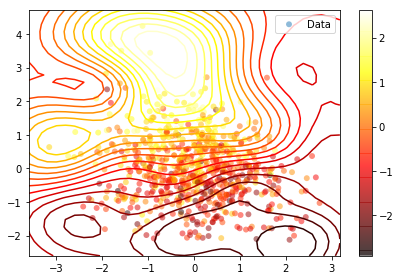

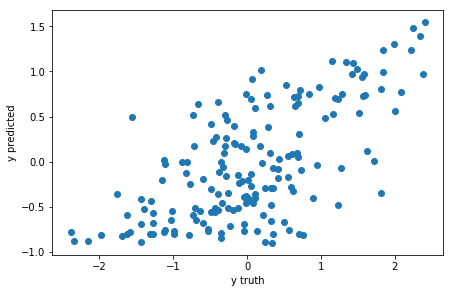

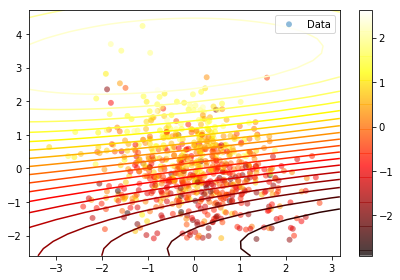

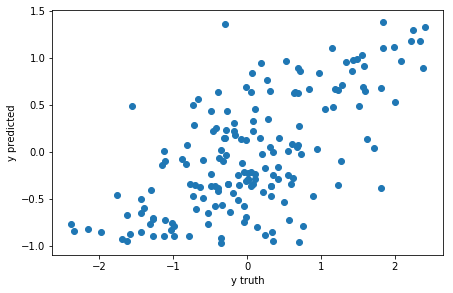

In [13]:
x = AdrTrn1[['GeneLength','Adrenal_mRNA']].values
y = AdrTrn1[['Adrenal_protein']].values

d = 2 # input dimension
var = 1. # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

x_test = AdrTst1[['GeneLength','Adrenal_mRNA']].values
y_test = AdrTst1[['Adrenal_protein']].values
m=testGP(x,y,x_test,y_test,k)

In [14]:
m

GP_regression.,value,constraints,priors
rbf.variance,0.892022739150605,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.6646147511376939,+ve,


In [15]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],8.50229807,+ve,
[1],2.68611805,+ve,


In [92]:
m.likelihood.variance.values

array([0.66301507])

In [120]:
m.kern = GPy.kern.src.rbf.RBF(input_dim=1, variance=1, lengthscale=1)

In [126]:
type(m)

GPy.models.gp_regression.GPRegression

In [124]:
m.rbf

rbf.,value,constraints,priors
variance,0.7876975368432455,+ve,
lengthscale,3.142994594486698,+ve,


In [ ]:
np.linalg.eigvals(C) # Computes the eigenvalues of a matrix

In [107]:
m.X.shape

(728, 2)

In [104]:
m.kern.K(m.X,m.X)

array([[0.78769754, 0.72075867, 0.75259119, ..., 0.68169352, 0.75590313,
        0.73269816],
       [0.72075867, 0.78769754, 0.69685551, ..., 0.52777187, 0.77454006,
        0.7831464 ],
       [0.75259119, 0.69685551, 0.78769754, ..., 0.71837808, 0.70582471,
        0.6876678 ],
       ...,
       [0.68169352, 0.52777187, 0.71837808, ..., 0.78769754, 0.56682899,
        0.52949445],
       [0.75590313, 0.77454006, 0.70582471, ..., 0.56682899, 0.78769754,
        0.78373023],
       [0.73269816, 0.7831464 , 0.6876678 , ..., 0.52949445, 0.78373023,
        0.78769754]])

In [97]:
m.kern.K(m.X)+np.eye(m.X.shape[0])*m.likelihood.variance.values

array([[1.4507126 , 0.72075867, 0.75259119, ..., 0.68169352, 0.75590313,
        0.73269816],
       [0.72075867, 1.4507126 , 0.69685551, ..., 0.52777187, 0.77454006,
        0.7831464 ],
       [0.75259119, 0.69685551, 1.4507126 , ..., 0.71837808, 0.70582471,
        0.6876678 ],
       ...,
       [0.68169352, 0.52777187, 0.71837808, ..., 1.4507126 , 0.56682899,
        0.52949445],
       [0.75590313, 0.77454006, 0.70582471, ..., 0.56682899, 1.4507126 ,
        0.78373023],
       [0.73269816, 0.7831464 , 0.6876678 , ..., 0.52949445, 0.78373023,
        1.4507126 ]])

In [80]:
x_test.shape

(173, 2)

In [79]:
covs.shape

(173, 173)

In [45]:
features

['D',
 'C',
 'Y',
 'H',
 'M',
 'P',
 'N',
 'R',
 'I',
 'S',
 'F',
 'Q',
 'L',
 'E',
 'W',
 'T',
 'G',
 'K',
 'V',
 'A',
 'CGC',
 'AUU',
 'UAU',
 'GAG',
 'UGA',
 'AAU',
 'GGU',
 'UGC',
 'ACU',
 'CAU',
 'UUG',
 'UAC',
 'GGC',
 'GGG',
 'UGG',
 'GUA',
 'AGC',
 'CCA',
 'UAG',
 'UUA',
 'AGG',
 'CGU',
 'CGA',
 'AAC',
 'GUG',
 'GCU',
 'CCC',
 'CUU',
 'GCC',
 'GAA',
 'UCA',
 'UCG',
 'ACC',
 'UCU',
 'AAA',
 'CGG',
 'GCA',
 'AGA',
 'CCU',
 'GAC',
 'GUC',
 'UAA',
 'CAG',
 'AUA',
 'AUC',
 'UCC',
 'CUG',
 'UUU',
 'ACG',
 'CUA',
 'GGA',
 'CAC',
 'GCG',
 'UGU',
 'CAA',
 'CCG',
 'CUC',
 'AAG',
 'AUG',
 'GUU',
 'ACA',
 'AGU',
 'GAU',
 'UUC',
 'Adrenal_mRNA',
 'Adrenal_protein',
 'GeneLength',
 'CDS_length',
 'UTR5_length',
 'UTR3_length',
 'transcript_counts',
 'cds_gc',
 'utr5_gc',
 'utr3_gc',
 'MolecularMass',
 'eq4Wright',
 'eq2Sun',
 'eq5Sun']

pearson r (array([-0.44191536]), array([1.15312754e-09]))
spearman rho SpearmanrResult(correlation=-0.4417843580145852, pvalue=1.1677252242785355e-09)


pearson r (array([0.67457699]), array([2.57651673e-24]))
spearman rho SpearmanrResult(correlation=0.6108438663599397, pvalue=4.502123851297636e-19)


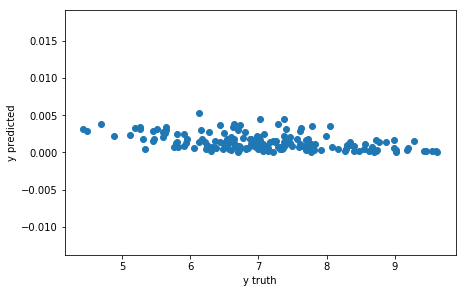

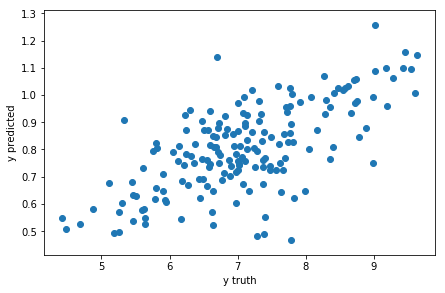

In [65]:
dims = AMINOACID_KEYS + ['CDS_length','MolecularMass','Adrenal_mRNA']
x = AdrTrn1[dims].values
y = AdrTrn1[['Adrenal_protein']].values
x_test = AdrTst1[dims].values
y_test = AdrTst1[['Adrenal_protein']].values
m = testGP(x,y,x_test,y_test)

TRY PCA on codon features or all features even

make a class to easy create multiple gp isntances, kernels? adr method, lengthscale, gp clustering?, different chromosomes, different subsets